# Multi Agent Collaboration Network

## Overview

A multi-agent network is an architecture that leverages a "divide-and-conquer" approach by breaking down complex tasks into smaller, specialized agents.

This helps resolve the inefficiencies of a single agent managing numerous tools, allowing each agent to focus on its area of expertise and solve problems effectively.

![network](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/03-Use-Cases/assets/17-langgraph-multi-agent-network.png?raw=1)

**Key Topics Covered**

- **Defining States** : How to define graph states and manage the state information required for each agent's actions  
- **Defining Tools** : How to specify tools that agents can use and add them as nodes  
- **Creating Agents** : How to define agents and set them as nodes in a LangGraph network  
- **Defining Agent Nodes** : How to define specialized agents as nodes  
- **Defining Tool Nodes** : How to define tools as nodes and enable agents to utilize them  
- **Defining Edge Logic** : How to set branching logic that directs agents or tools based on the results of an agent’s task  
- **Graph Definition** : How to combine agents, tools, states, and edge logic into a cohesive graph  
- **Running the Graph** : How to execute the graph and perform real-world tasks with the defined setup  

Let's get started!

### References

- [Concept of Multi Agent Network LangGraph](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network)  
- [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation (Wu et al.)](https://arxiv.org/abs/2308.08155)  
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
Check out the  [```langchain-opentutorial```](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
!python -m pip install langchain-opentutorial==0.0.4

You can set API keys in a ```.env``` file or set them manually.

[Note] If you’re not using the ```.env``` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

## Why Do We Use Multi-Agent Networks?

A single agent can be efficient when working within a specific domain and using a limited number of tools. However, as the number of tools increases, several challenges arise:  
1. The logic for managing tools becomes increasingly complex.  
2. The amount of information the agent needs to process at once grows, leading to inefficiencies.

By adopting a "divide-and-conquer" approach, each agent focuses on a specific task or area of expertise, while the overall workload is distributed across a network.  
Each agent handles what it does best and delegates tasks to other specialized agents or utilizes tools effectively when needed.

This structure enhances efficiency and simplifies the management of complex workflows.

## Defining States

```messages``` is a list of messages shared between agents, and ```sender``` refers to the sender of the most recent message.

In [3]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage

from langgraph.graph import MessagesState

# Defining state
class AgentState(MessagesState):
    messages: Annotated[
        Sequence[BaseMessage], operator.add
    ]  # a list of messages shared between agents
    sender: Annotated[str, "The sender of the last message"]

## Defining Tools

Here, we define a few tools that agents will use in the network:

- ```TavilySearch``` : A tool for searching information on the internet. It is used by the ```research_agent``` to find the necessary data.  
- ```PythonREPL``` : A tool for executing Python code. It is used by the ```chart_agent``` to create charts.  

In [4]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Defining tavily web search tool
tavily_tool = TavilySearchResults(max_results=5)

# Defining a tool for executing python code
python_repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = python_repl.run(code)
    except BaseException as e:
        return f"Failed to execute code. Error: {repr(e)}"

    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

/tmp/ipykernel_5469/1994749818.py:8: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


## Creating Agents

Here’s an example of how to create agents. In this tutorial, we’ll use the Research Agent and the Chart Generator Agent to build a multi-agent network.


First, define the LLM model and a common system prompt to be used for the agents.

In [5]:
from langchain_openai import AzureChatOpenAI

# Defining LLM
llm = AzureChatOpenAI(model="gpt4o")

In [6]:
# Defining common system prompt
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, you can identify your part for the task and then another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

### Research Agent

Create an agent that performs research using the ```TavilySearch``` tool. This agent is used to gather the required information.

In [7]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState


research_agent_system_prompt = """
You can only do research. You are working with a chart generator colleague.
for any given task, identify if you can research and get information/data, provide that to another agent.
"""

# Create Research Agent
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    #state_schema=AgentState,
    prompt=make_system_prompt(research_agent_system_prompt),
)


# Defining Research Agent Node
def research_node(state: MessagesState) -> MessagesState:
    result = research_agent.invoke(state)

    last_message = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return {
        "messages": [last_message],
    }

### Chart Generator Agent

Create an agent that generates charts using the ```PythonREPL``` tool. This agent is used to create charts.

In [8]:
chart_generator_system_prompt = """
You can only generate charts. You are working with a researcher colleague.
Be sure to use the following font code in your code when generating charts.

Execute the generated final code using the tool python_repl_tool.
Make sure to use data provided by reasearcher agent only, do not use random values/data to plot.
"""

# Create Chart Generator Agent
chart_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    prompt=make_system_prompt(chart_generator_system_prompt),
)


# Defining Chart Generator Agent Node
def chart_node(state: MessagesState) -> MessagesState:
    result = chart_agent.invoke(state)

    last_message = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return {
        "messages": [last_message],
    }

## Building a Multi-Agent Graph

This workflow uses LangGraph to build a **multi-agent system** where agents collaborate dynamically.

The ```router``` decides the next step by analyzing messages—either continuing to the next node or ending the workflow.

Each node, like ```researcher``` and ```chart_generator```, is connected using **conditional edges** that determine the workflow’s flow based on the router's logic. The system starts with the ```researcher``` and alternates between agents until a "FINAL ANSWER" is reached.

In [9]:
!sudo apt install -y graphviz graphviz-dev pkg-config

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-9ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-9ubuntu0.1).
pkg-config is already the newest version (1.8.1-2build1).
The following packages were automatically installed and are no longer required:
  libgl1-amber-dri libglapi-mesa
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [10]:
#  
!python -m pip install pygraphviz --quiet

  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [98 lines of output]
      /tmp/pip-build-env-xg7zsgvs/overlay/lib/python3.12/site-packages/setuptools/config/_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
      
              By 2026-Feb-18, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              ****************************************************************

In [13]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


# Defining Router
def router(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"


# Building a multi-agent network workflow
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "chart_generator", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "researcher", END: END},
)

workflow.add_edge(START, "researcher")
app = workflow.compile(checkpointer=MemorySaver())
app

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [14]:
# sudo apt install graphviz graphviz-dev pkg-config 
# pip install pygraphviz
from IPython.display import display,Image
display(Image(app.get_graph(xray=True).draw_mermaid_png()))


ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

Let's take a look at the graph we’ve created by visualizing it!

## Running the Agents

Now it’s time to execute the multi-agent workflow we’ve built!

Using the ```RunnableConfig```, we set up necessary configurations like recursion limits and unique thread IDs.

Then, we input a query and invoke the graph, allowing the agents to collaborate and generate results based on the workflow.


Here’s an example of code that visualizes CO2 emissions from 2015 to 2024. If you’re curious about something else, try changing the query and see how well the agents handle it!

[NOTE] As of January 22 2025, GPT-4o's maximum context length is 128,000 tokens. Depending on the query, you might exceed this limit and encounter an error. If that happens, consider refining the agent graph or modifying your query.

In [ ]:
#!pip install --quiet langchain_opentutorial


🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_yioU4igzGcvmWUAPQbEe1JMu)
 Call ID: call_yioU4igzGcvmWUAPQbEe1JMu
  Args:
    query: global per capita GDP statistics 2015 to 2024

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_VD57ZQlyr7938cxFlnKEtBfd)
 Call ID: call_VD57ZQlyr7938cxFlnKEtBfd
  Args:
    query: global per capita GDP data 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024

🔄 Node: agent in [researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_q0VYfBh5RRd7vnAehvMBIRnG)
 Call ID: call_q0VYfBh5RRd7vnAehvMBIRnG
  Arg

Python REPL can execute arbitrary code. Use with caution.



🔄 Node: agent in [chart_generator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  python_repl_tool (call_lTSlKrtXEHxgl97o60QJtd1a)
 Call ID: call_lTSlKrtXEHxgl97o60QJtd1a
  Args:
    code: import matplotlib.pyplot as plt

# Data for global per capita GDP
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
pGDP = [10476, 10354, 10603, 11128, 11419, 10916, 12353, 12737, 13170, 13647]

# Creating the plot
plt.figure(figsize=(10,5))
plt.plot(years, pGDP, marker='o')
plt.title('Global Per Capita GDP (2015 - 2024)')
plt.xlabel('Year')
plt.ylabel('GDP per Capita (USD)')
plt.xticks(years)
plt.grid(True)
plt.gca().set_facecolor('#f0f0f0')
plt.gca().xaxis.label.set_fontsize(12)
plt.gca().yaxis.label.set_fontsize(12)
plt.gca().title.set_fontsize(14)
plt.gca().tick_params(axis='both', which='major', labelsize=10)

# Show the plot
plt.tight_layout()
plt.savefig('/mnt/data/global_pe

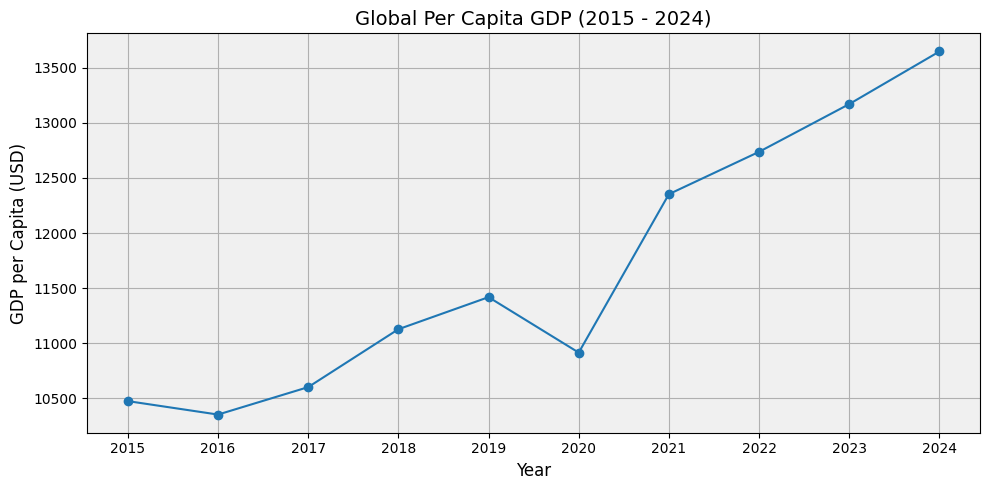

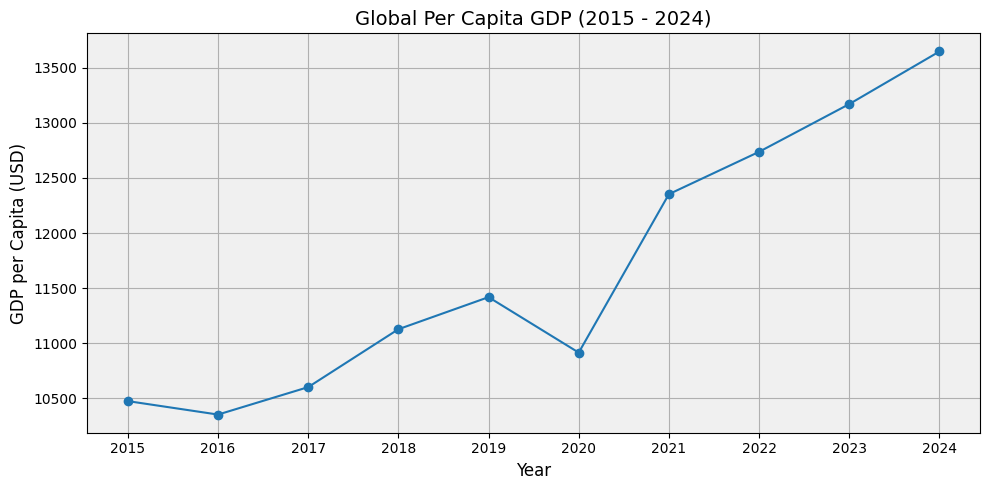

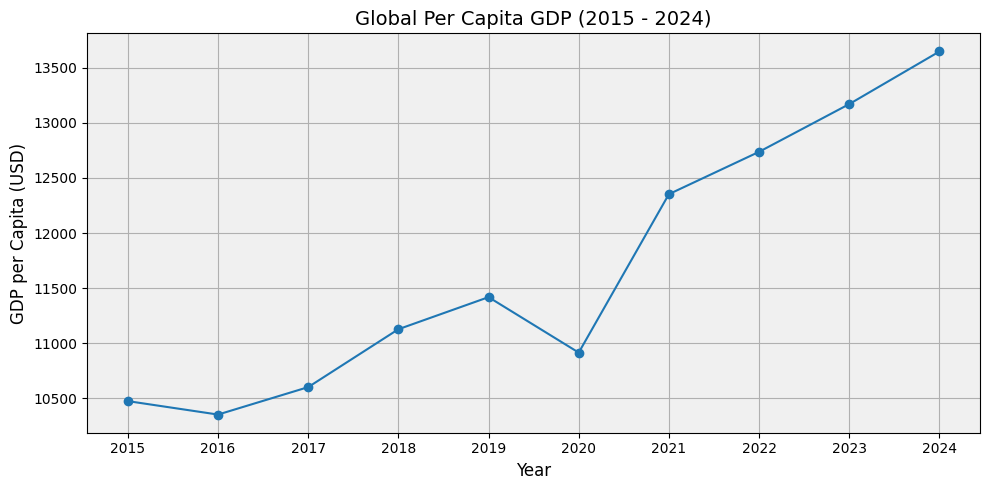


🔄 Node: agent in [chart_generator] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

FINAL ANSWER

The chart visualizing the global per capita GDP from 2015 to 2024 has been successfully created. You can download it using the following link:

[Download Global Per Capita GDP Chart](sandbox:/mnt/data/global_per_capita_gdp_2015_2024.png)

🔄 Node: chart_generator 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================
Name: chart_generator

FINAL ANSWER

The chart visualizing the global per capita GDP from 2015 to 2024 has been successfully created. You can download it using the following link:

[Download Global Per Capita GDP Chart](sandbox:/mnt/data/global_per_capita_gdp_2015_2024.png)


In [15]:
from langchain_core.runnables import RunnableConfig
from langchain_opentutorial.messages import invoke_graph, random_uuid

# set up config (recursion_limit, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# input query
inputs = {
    "messages": [
        HumanMessage(
            content="Visualize the global per capita GDP from 2015 to 2024."
        )
    ],
}

# invoke graph
invoke_graph(app, inputs, config, node_names=["researcher", "chart_generator", "agent"])

# Multi-Agent Supervisor

Now, we'll explore how to build **a multi-agent system** using **LangGraph** , efficiently coordinate tasks between agents, and manage them through **a Supervisor** .  
We'll cover handling multiple agents simultaneously, managing each agent to perform their role, and properly handling task completion.

**Key Points** :
- The Supervisor brings together various expert agents and operates them as a single team.
- The Supervisor agent monitors the team's progress and executes logic such as calling appropriate agents for each step or terminating tasks.

<div align="center">
  <img src="https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/03-Use-Cases/assets/07-langgraph-multi-agent-supervisor.png?raw=1"/>
</div>


## Setting State

Define **state** to be used in the multi-agent system.

In [ ]:
import operator
from typing import Annotated, Sequence

from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict


class AgentState(TypedDict):
    """Define state to be used in the multi-agent system."""
    messages: Annotated[Sequence[BaseMessage], operator.add]  # messages
    next: str  # next agent to route to

## Creating Agents

### Creating Tools

In this example, we'll create agents that use a search engine to perform web research and generate plots.

Define the tools to be used below.

- **Research** : Use ```TavilySearch``` tool to perform web research. To use this tool, you need to set the ```TAVILY_API_KEY``` . Please refer to [previous tutorial](https://langchain-opentutorial.gitbook.io/langchain-opentutorial/15-agent/01-tools#search-api-tooltavily) for more details.
- **Coder** : Use ```PythonREPLTool``` tool to run code.

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool


# Initialize Tavily search tool that returns up to 5 search results
tavily_tool = TavilySearchResults(max_results=5)

# Initialize Python REPL tool that runs code locally (may not be safe)
python_repl_tool = PythonREPLTool()

### Creating Utility for Creating Agents

When building a multi-agent system using LangGraph, **helper functions** play a crucial role in creating and managing agent nodes. These functions enhance code reusability and simplify interactions between agents.

- **Creating Agent Nodes** : Define functions to create nodes for each agent's role
- **Managing Workflow** : Provide utilities to manage the workflow between agents
- **Error Handling** : Include mechanisms to handle errors that may occur during agent execution

The following is an example of defining a function called ```agent_node``` .

This function creates an agent node using the given state and agent. We will call this function later using ```functools.partial``` .

In [ ]:
from langchain_core.messages import HumanMessage


# Create an agent node using the specified agent and name
def agent_node(state, agent, name):
    # Call the agent
    agent_response = agent.invoke(state)
    # Convert the last message of the agent to a HumanMessage and return it
    return {
        "messages": [
            HumanMessage(content=agent_response["messages"][-1].content, name=name)
        ]
    }

Below is an example of creating a ```research_node``` using ```functools.partial``` .

In [ ]:
import functools

from langchain_openai import AzureChatOpenAI
from langgraph.prebuilt import create_react_agent


# Create a Research Agent
research_agent = create_react_agent(AzureChatOpenAI(model="gpt4o"), tools=[tavily_tool])

# Create a Research Node
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")


> **Note**
>
> Role of ```functools.partial```
>
> ```functools.partial``` is used to create a new function by fixing some arguments or keyword arguments of an existing function. In other words, it helps simplify commonly used function call patterns.
>
> **Roles**
>
> 1. **Create new function with predefined values** : Returns a new function with some arguments of the existing function pre-specified.
> 2. **Code simplification** : Reduces code duplication by simplifying commonly used function call patterns.
> 3. **Improved readability** : Customizes function behavior for specific tasks to make it more intuitive to use.
>
> **Example code**
> ```python
> research_node = functools.partial(agent_node, agent=research_agent, names="Researcher")
> ```
>
> 1. Assume there is an existing function called ```agent_node``` .
>    - This function can accept multiple arguments and keyword arguments.
>
> 2. ```functools.partial``` fixes the values ```agent=research_agent``` and ```names="Researcher"``` for this function.
>    - This means that ```research_node``` no longer needs to specify the ```agent``` and ```names``` values when calling ```agent_node``` .
>    - For example:
>     ```python
>     agent_node(state, agent=research_agent, names="Researcher")
>     ```
>     Instead, you can use:
>     ```python
>     research_node(state)
>     ```

Let's run the code and check the results.

In [ ]:
research_node(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
)

{'messages': [HumanMessage(content='Here’s a simple code snippet to print "Hello, World!" to the terminal in a few different programming languages:\n\n### Python\n```python\nprint("Hello, World!")\n```\n\n### JavaScript (Node.js)\n```javascript\nconsole.log("Hello, World!");\n```\n\n### Java\n```java\npublic class HelloWorld {\n    public static void main(String[] args) {\n        System.out.println("Hello, World!");\n    }\n}\n```\n\n### C\n```c\n#include <stdio.h>\n\nint main() {\n    printf("Hello, World!\\n");\n    return 0;\n}\n```\n\n### Ruby\n```ruby\nputs "Hello, World!"\n```\n\nYou can run any of these snippets in their respective environments to display "Hello, World!" in the terminal.', additional_kwargs={}, response_metadata={}, name='Researcher')]}

### Creating Agent Supervisor

Create an agent that manages and supervises agents.

In [ ]:
from typing import Literal

from pydantic import BaseModel


# Define the list of member agents
members = ["Researcher", "Coder"]

# Define the list of options for selecting the next worker
options_for_next = ["FINISH"] + members

# Define the response model for selecting the next worker: indicates selecting the next worker or completing the task
class RouteResponse(BaseModel):
    next: Literal[*options_for_next]

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI


# Define the system prompt: a supervisor tasked with managing a conversation between workers
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Create ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options_for_next), members=", ".join(members))

# Initialize LLM
llm = AzureChatOpenAI(model="gpt4o", temperature=0)

# Create Supervisor Agent
def supervisor_agent(state):
    # Combine prompt and LLM to create a chain
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)
    # Call the agent
    return supervisor_chain.invoke(state)

## Constructing the Graph

Now, we're ready to build the graph. Below, we'll use the functions we just defined to define ```state``` and ```worker``` nodes.

In [ ]:
import functools

from langgraph.prebuilt import create_react_agent


# Create Research Agent
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

code_system_prompt = """
Be sure to use the following font in your code for visualization.

##### Font Settings #####
import matplotlib.pyplot as plt

# Set universal font settings
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False  # Prevent minus sign from breaking

# Set English locale
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
"""

# Create Coder Agent
coder_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    prompt=code_system_prompt,
)
coder_node = functools.partial(agent_node, agent=coder_agent, name="Coder")

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph


# Create graph
workflow = StateGraph(AgentState)

# Add nodes to the graph
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", coder_node)
workflow.add_node("Supervisor", supervisor_agent)

# Add edges from member nodes to the Supervisor node
for member in members:
    workflow.add_edge(member, "Supervisor")

# Add conditional edges
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END

def get_next(state):
    return state["next"]

# Add conditional edges from the Supervisor node
workflow.add_conditional_edges("Supervisor", get_next, conditional_map)

# Add starting point
workflow.add_edge(START, "Supervisor")

# Compile the graph
graph = workflow.compile(checkpointer=MemorySaver())

Visualize the graph.

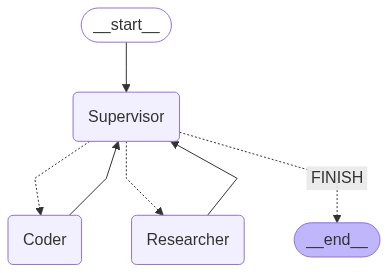

In [ ]:
graph

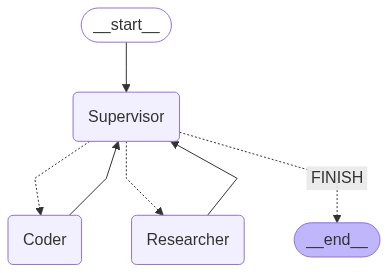

In [ ]:
# sudo apt install graphviz graphviz-dev pkg-config 
# pip install pygraphviz
from IPython.display import display,Image
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

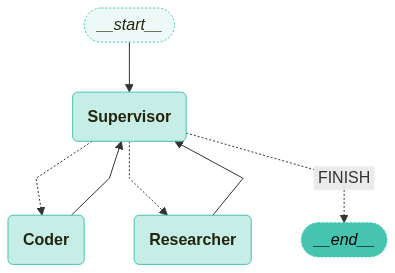

In [ ]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(graph)

## Calling the Team

Now, we can check the performance by calling the graph.


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
Researcher

🔄 Node: agent in [Researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Kk7EO4aaUxbuqN5xsmRZcQrv)
 Call ID: call_Kk7EO4aaUxbuqN5xsmRZcQrv
  Args:
    query: South Korea GDP per capita 2010 to 2024

🔄 Node: tools in [Researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "South Korea - gross domestic product (GDP) per capita 1989-2030", "url": "https://www.statista.com/statistics/939347/gross-domestic-product-gdp-per-capita-in-south-korea/", "content": "The gross domestic product (GDP) per capita in South Korea was forecast to continuously increase between 2024 and 2030 by in total 5,762.76 U.S. dollars (+15.95 percent). After 

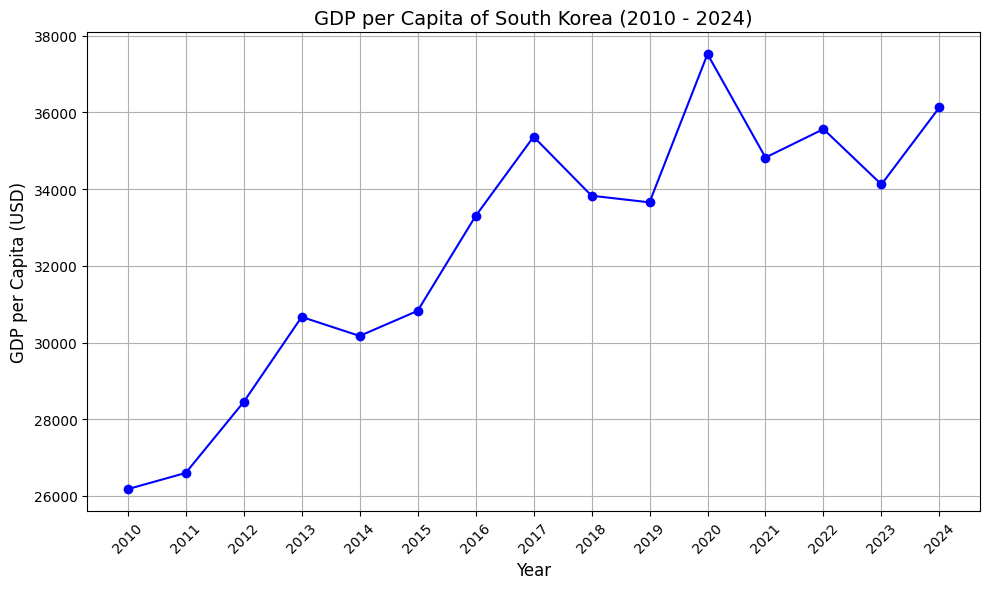


🔄 Node: tools in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: Python_REPL


🔄 Node: agent in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  Python_REPL (call_FRudTgIVG1Nnz01fuLhNiRkw)
 Call ID: call_FRudTgIVG1Nnz01fuLhNiRkw
  Args:
    query: import matplotlib.pyplot as plt
import numpy as np

# Data for GDP per capita of South Korea from 2010 to 2024
years = np.array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])
gdp_per_capita = np.array([26177.94, 26600.55, 28449.36, 30667.09, 30171.79, 30825.52, 33296.98, 35363.95, 33826.94, 33653.20, 37518.47, 34822.41, 35563.05, 34121.02, 36128.99])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(years, gdp_per_capita, marker='o', linestyle='-', color='b')
plt.title('GDP per Capita of 

In [ ]:
import uuid

from langchain_core.runnables import RunnableConfig
from langchain_opentutorial.messages import invoke_graph

# Set config (recursion limit, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": str(uuid.uuid4())})

# Set input (question)
inputs = {
    "messages": [
        HumanMessage(
            content="Visualize the GDP per capita of South Korea from 2010 to 2024."
        )
    ],
}

# Run the graph
invoke_graph(graph, inputs, config)